In [23]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sns.set_theme()

# Matrix size comparison

## Firmware dimensions

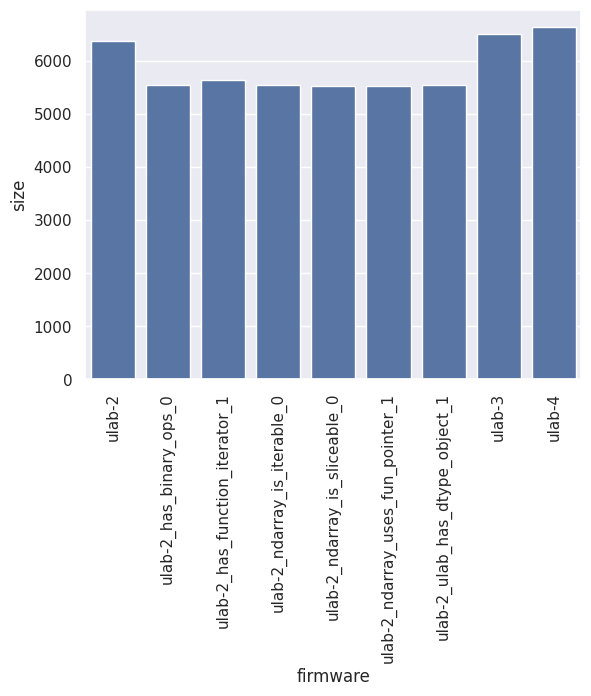

In [24]:
firmware_size = pd.read_csv("sizes.csv")
sns.barplot(data=firmware_size, x="firmware", y="size")
plt.xticks(rotation=90)
plt.show()

## Performance comparison

In [25]:
import os
from pathlib import Path

times_directory = Path("times")
firmwares = []
# for filename in os.listdir(times_directory):
for file in times_directory.iterdir():
	if not file.is_file() or not file.suffix == ".csv":
		continue
	times = pd.read_csv(str(file))
	times["firmware"] = file.stem
	firmwares.append(times)

results = pd.concat(firmwares)

results

# firmwares = {
# 	"python": pd.read_csv("times/[NUMPY] times.csv"),
# 	"2d": pd.read_csv("times/[ULAB] 2 times.csv"),
# 	"3d": pd.read_csv("times/[ULAB] 3 times.csv"),
# 	"4d": pd.read_csv("times/[ULAB] 4 times.csv"),
# }

,test name,id,time,valid,firmware
0,matrix multiplication,0,3.346920,True,ulab-2_has_function_iterator_1
1,matrix multiplication,1,3.480196,True,ulab-2_has_function_iterator_1
2,matrix multiplication,2,3.417969,True,ulab-2_has_function_iterator_1
3,matrix multiplication,3,4.235983,True,ulab-2_has_function_iterator_1
4,matrix multiplication,4,4.173040,True,ulab-2_has_function_iterator_1
...,...,...,...,...,...
3995,linear system,995,0.018120,True,ulab-2_ndarray_is_iterable_0
3996,linear system,996,0.017881,True,ulab-2_ndarray_is_iterable_0
3997,linear system,997,0.016928,True,ulab-2_ndarray_is_iterable_0
3998,linear system,998,0.016928,True,ulab-2_ndarray_is_iterable_0


In [26]:
# for name, filename in firmwares.items():
# 	filename["firmware"] = name
# results = pd.concat(firmwares.values())
# results

In [27]:
invalid = results.loc[results["valid"] == False]
invalid_firmwares = invalid["firmware"].unique()
print(f"there are {len(invalid)} invalid tests from the firmwares:{invalid_firmwares}")

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

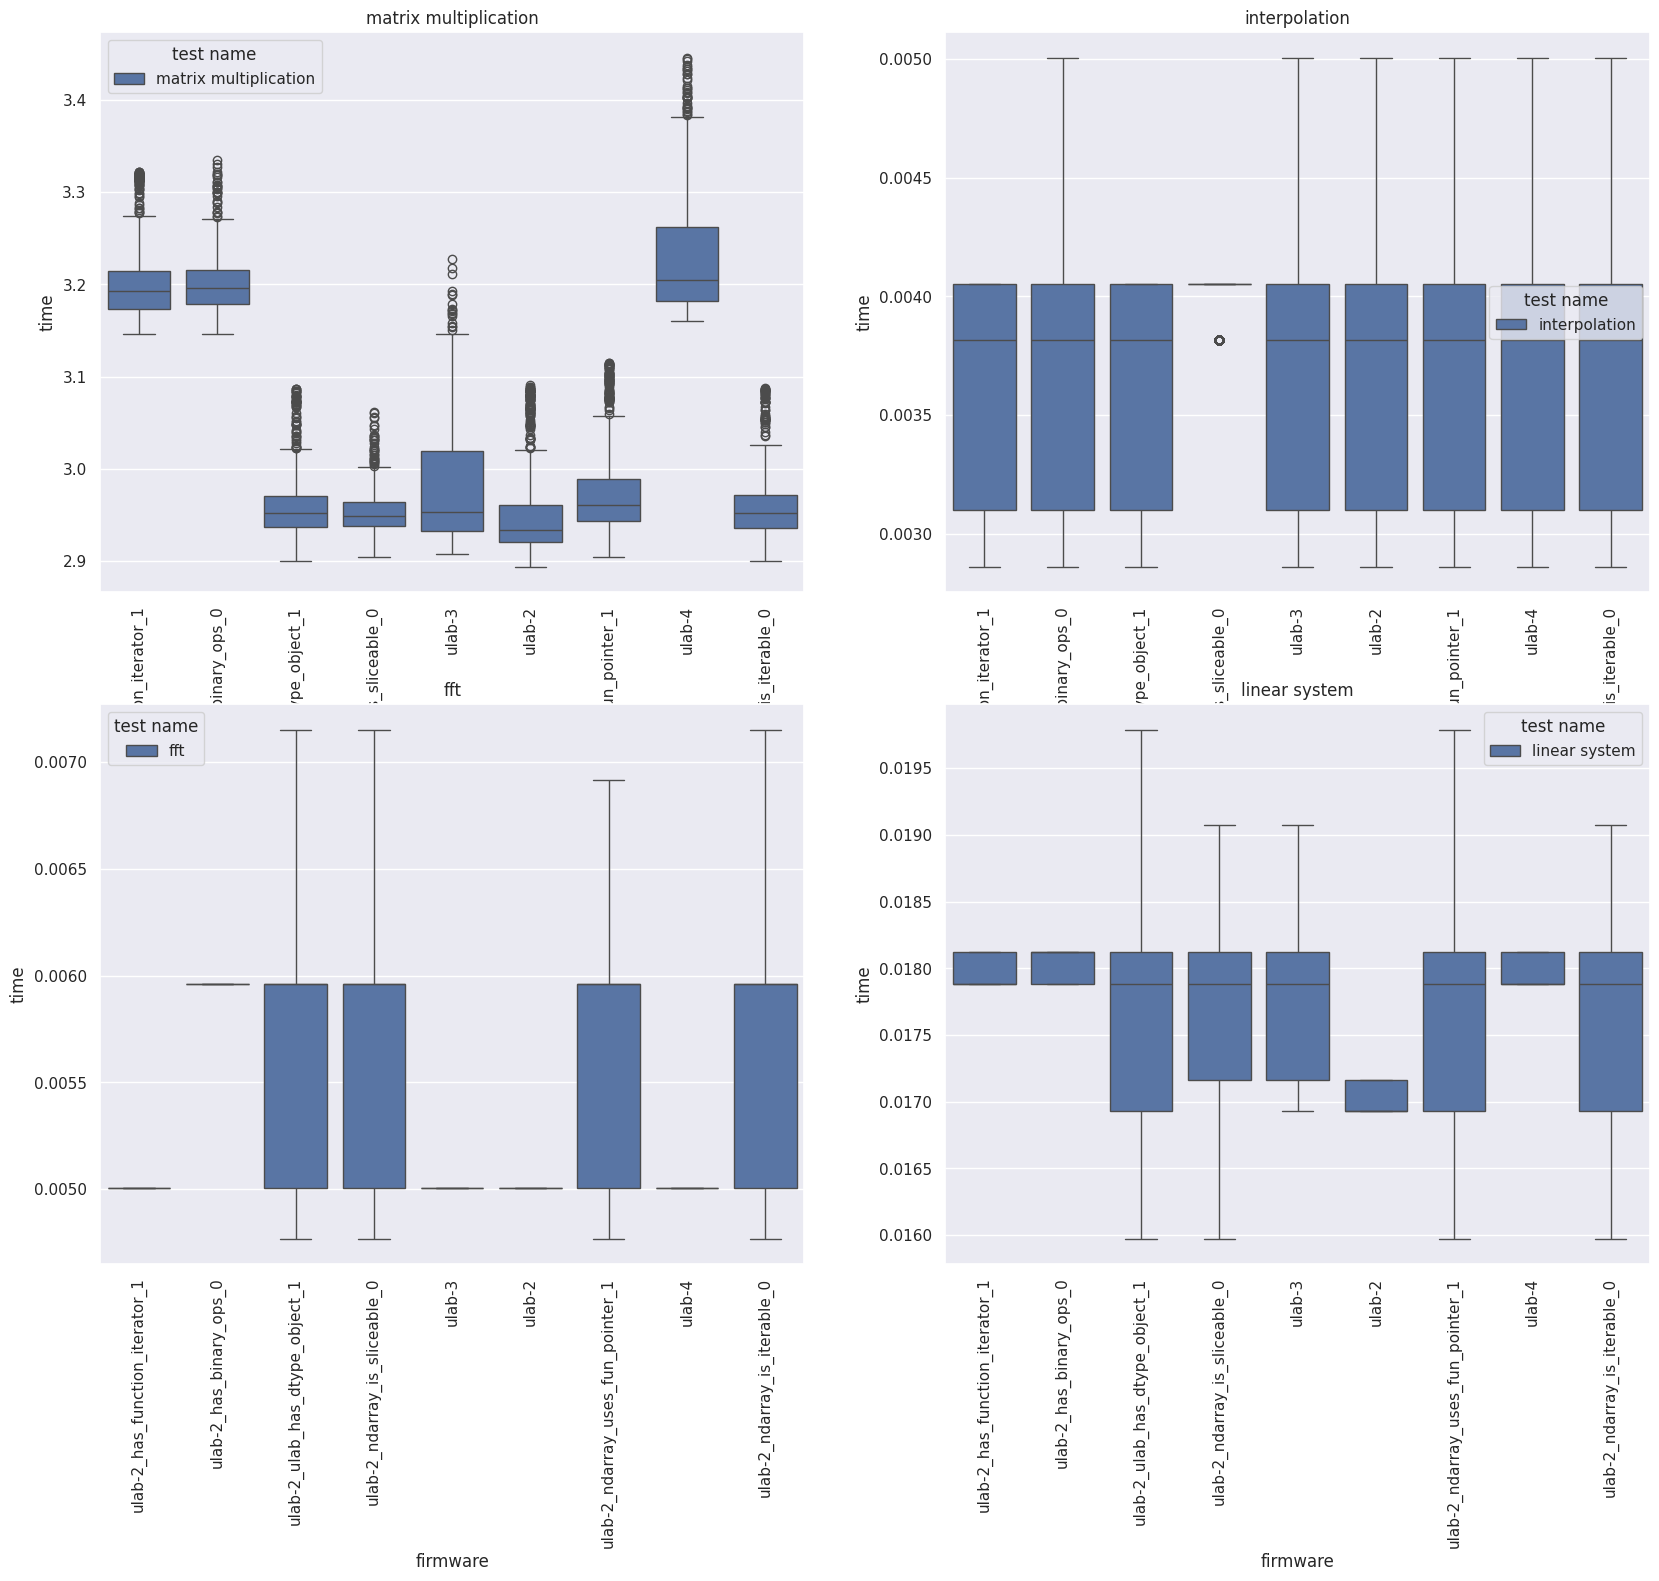

In [ ]:
import math

# follows the iqr (interquantile range rule)
def remove_outliers(df, column):
    firmwares = df["firmware"].unique()
    bounded = []
    for f in firmwares:
        f_data = df.loc[df["firmware"] == f]
        Q1 = f_data[column].quantile(0.25)
        Q3 = f_data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        bounded.append(f_data.loc[(f_data[column] >= lower_bound) & (f_data[column] <= upper_bound)])
    return pd.concat(bounded)

columns = 2
tests = results["test name"].unique()
fig, axes = plt.subplots(2, math.ceil(float(len(tests)) / 2), figsize=(20, 16))
for test, ax in zip(tests, axes.flatten()):
    test_data = results.loc[results["test name"] == test]
    no_outliers = remove_outliers(test_data, "time")
    ax.tick_params(axis="x", rotation=90)
    sns.boxplot(data=no_outliers, ax=ax, x="firmware", y="time", hue="test name")
    ax.set_title(test)
plt.show()

In [ ]:
aggregate = results.groupby(['firmware', 'test name'])["time"].agg(["min", "max", "median", "std"]).reset_index()
aggregate

,firmware,test name,min,max,median,std
0,ulab-2,fft,0.004768,0.207901,0.005007,0.010586
1,ulab-2,interpolation,0.002861,0.199080,0.003815,0.008401
2,ulab-2,linear system,0.016928,0.199080,0.016928,0.021390
3,ulab-2,matrix multiplication,2.893925,4.953146,2.939939,0.148541
4,ulab-2_has_binary_ops_0,fft,0.004768,0.189066,0.005960,0.008193
5,ulab-2_has_binary_ops_0,interpolation,0.002861,0.174999,0.003815,0.007524
6,ulab-2_has_binary_ops_0,linear system,0.015974,0.180960,0.017881,0.021529
7,ulab-2_has_binary_ops_0,matrix multiplication,3.145933,3.775120,3.204107,0.090359
8,ulab-2_has_function_iterator_1,fft,0.003815,0.190020,0.005007,0.009916
9,ulab-2_has_function_iterator_1,interpolation,0.002861,0.213861,0.003815,0.006772
